# Visualizing Global Viticultural Climate Zones
#### Author: Andras Gelanyi
### Notebook for Preparing spatial and temporal data sets
This notebook is used for extracting, flattening, enriching and transforming NetCDF climate data to GeoJSON objects storing the spatial aspects as well. Apart from technical transformations, some data aggregations and domain specific tasks (growing-season details, etc.) were also completed.

Note: This notebook works on __huge__ datasets. There are blocks that will run for hours even on a modern computer and RAM usage will exceed 100GBs.


In [1]:
# Importing required of libraries
import math
import json
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

Data from NOAA and UDel. The raw sets can be accessed [here](https://psl.noaa.gov/data/gridded/data.UDel_AirT_Precip.html).

Reading the NetCDF climate set.

In [2]:
# https://psl.noaa.gov/data/gridded/data.UDel_AirT_Precip.html

# Monthly mean air temperatures between 1900 and 2017
f = netCDF4.Dataset('noaa_data/air.mon.mean.v501.nc')

In [4]:
# Getting all the variables
# Fortunately, NetCDF is a self-describing format.
print(f)
print(f.variables.keys())

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    history: created 2/2016 by CAS NOAA/ESRL PSD
    version: 5.01
    dataset_title: Terrestrial Air Temperature and Precipitation: 1900-2017 Gridded Monthly Time Series
    Source: http://climate.geog.udel.edu/~climate/html_pages/download.html
    References: https://www.psl.noaa.gov/data/gridded/data.UDel_AirT_Precip.html
    title: Terrestrial Air Temperature and Precipitation: V5.01
    dimensions(sizes): lat(360), lon(720), time(1416)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 air(time, lat, lon)
    groups: 
dict_keys(['lat', 'lon', 'time', 'air'])


In [5]:

# Getting series from NetCDF variables
# Based on : http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html

lats = f.variables['lat'][:]
lons = f.variables['lon'][:]
time = f.variables['time'][:]
air = f.variables['air'][:]

print(lats.shape)
print(lons.shape)
print(time.shape)
print(air.shape)

(360,)
(720,)
(1416,)
(1416, 360, 720)


The following block _flattens_ the dataset. It is not the perfect approach, but this way, we can use standard Python numerical tools (Pandas, GeoPandas and Numpy) for mangling the set.

Note: It takes a long time (2hrs) to perform the iterations and 100+ GB virtual memory allocated

In [5]:
# Building a *huge* dataframe
# This block is executed only once

# This is going to be my dataframe
df = pd.DataFrame(columns=['year', 'month', 'lat', 'lon', 'temp'])
list = []

count = 0
# Looping through multiple dimensions
# A "knowledge" of the structure (temporal aspects, structs) is needed
for t, a_time in zip(time.astype(int), air):
    year = math.floor(t/(365*24)) + 1900
    month = count%12

    for lat, a_lat in zip(lats, a_time):
         #print(a_lat.shape)
         #print(f"lat: {lat} a: {a_lat[38:44]}")

        for lon, a in zip(lons,  a_lat):
             #print(a_lon.shape)
             #print(f"period: {year}/{month} lat: {lat} lon: {lon} temp: {a}")

            if a is not np.ma.masked:
                 # List operations
                 list.append([year, month, lat, lon, a])
                 #print(f"period: {year}/{month} lat: {lat} lon: {lon} temp: {np.nan}")
            else:
                 # List operations
                 list.append([year, month, lat, lon, np.nan])
                 #print(f"period: {year}/{month} lat: {lat} lon: {lon} temp: {a}")

    count += 1

# DEBUG, working on one entry only
#    if count > 1:
#        break


# 1410 iterations -> 80 minutes dataframe build (90mins gzip)-> 12GB memory

In [6]:
# Saving the dataframe to disk
# This block is executed only once
df = pd.DataFrame(list, columns=['year', 'month', 'lat', 'lon', 'air_temp'])
df.to_csv('noaa_data/air_temp.csv.gz', compression='gzip') # 90 minutes

In [7]:
%%time

# Reading the dataframe from the disk
df = pd.read_csv('df/air_temp.csv.gz', compression='gzip') # 4 minutes

df.info()
df.shape

Building a dataframe to host the temperature data *only* for the viticultural zones. Focusing on the growing months as per the northern or southern the hemisphere.

Storing the dataframe and compressing it.

The block is running for approx. __10 minutes__.

In [8]:
%%time

# Global viticulture zones
# https://winegourd.blogspot.com/2018/03/
# Ideal: 12-22C isotherms (average)
# Northern hemisphere: Apr - Oct
# Southern hemisphere: Oct - Apr
# 0 Jan; 1 Feb; 2 Mar; 3 Apr; 4 May; 5 Jun; 6 Jul; 7 Aug; 8 Sep; 9 Oct; 10 Nov; 11 Dec

# DEBUG: looking at only one year
#temp = df[df['year'] == 1900]

northern = df[(df['month'].isin([3, 4, 5, 6, 7, 8, 9])) & (df['lat'] >= 0)]
southern = df[(df['month'].isin([9,10,11, 0, 1, 2, 3])) & (df['lat'] < 0)]

viticultural_zone = pd.concat([northern, southern]).groupby(['year', 'lat', 'lon'])['air_temp'].mean()
viticultural_zone.to_csv('noaa_data/viticultural_zone_mean_temp.csv.gz', compression='gzip')


In [9]:
# Loading the dataset from the disk
# Takes approx. 20 seconds and 1GB memory
viticultural_zone = pd.read_csv('noaa_data/viticultural_zone_mean_temp.csv.gz', compression='gzip')
viticultural_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30585600 entries, 0 to 30585599
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   year      int64  
 1   lat       float64
 2   lon       float64
 3   air_temp  float64
dtypes: float64(3), int64(1)
memory usage: 933.4 MB


In [10]:
# Adding a field for marking the data points that are considered in range
temp_min = 12.0
temp_max = 22.0
viticultural_zone['is_in_temp_range'] = viticultural_zone['air_temp'].between(temp_min, temp_max, inclusive='both')

# We will work only on data that is within the temperature range se
in_range = viticultural_zone[viticultural_zone['is_in_temp_range'] == True]

in_range.info()

# Fixing the longitudes, our normal range should be between -180 and 180 degrees
in_range.loc[ in_range.lon > 180, 'lon' ] = in_range.lon - 360.0 

# Indexing the dataframe along the years
in_range.set_index('year', inplace=True)

# Let' sse how it looks
print(in_range)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1653716 entries, 57456 to 30541700
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   year              1653716 non-null  int64  
 1   lat               1653716 non-null  float64
 2   lon               1653716 non-null  float64
 3   air_temp          1653716 non-null  float64
 4   is_in_temp_range  1653716 non-null  bool   
dtypes: bool(1), float64(3), int64(1)
memory usage: 64.7 MB
        lat    lon   air_temp  is_in_temp_range
year                                           
1900 -50.25 -71.75  12.042857              True
1900 -50.25 -70.25  12.528571              True
1900 -49.75 -69.75  12.400000              True
1900 -49.75 -69.25  13.428572              True
1900 -49.75 -68.75  12.485714              True
...     ...    ...        ...               ...
2017  58.75  13.75  12.642857              True
2017  58.75  17.25  12.228571              True


#### Building yearly GeoJSON files

The following block is used to build and store the yearly dataset used by our website. Format is GeoJSON, for speeing things up, we are building it by hand.

In [ ]:
import json


for year in range(1900, 2018):

    data = json.loads(in_range.loc[year].reset_index().to_json(orient="records"))

    geojson = {
        "type": "FeatureCollection",
        "features": [
        {
            "type": "Feature",
            "geometry" : {
                "type": "Point",
                "coordinates": [d["lon"], d["lat"]],
                },
            "properties" : {
                "year": d["year"],
                "air_temp": round(d["air_temp"],2) ,
                "in_range": d["is_in_temp_range"]
            }
        } for d in data]
    }

    with open(f"noaa_data/web_data/viticultural_zone_mean_temp_{year}.geojson", 'w') as json_file:
        json.dump(geojson, json_file)

#print(json.dumps(geojson, indent=4))

#### Initial plots using Python
The following blocks are used to generate some images for selected years (1900 ad 2010) and to create a GIF animation that can be shown even on a static page.

C:\Users\agelanyi\AppData\Local\Temp\ipykernel_12180\2978231894.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


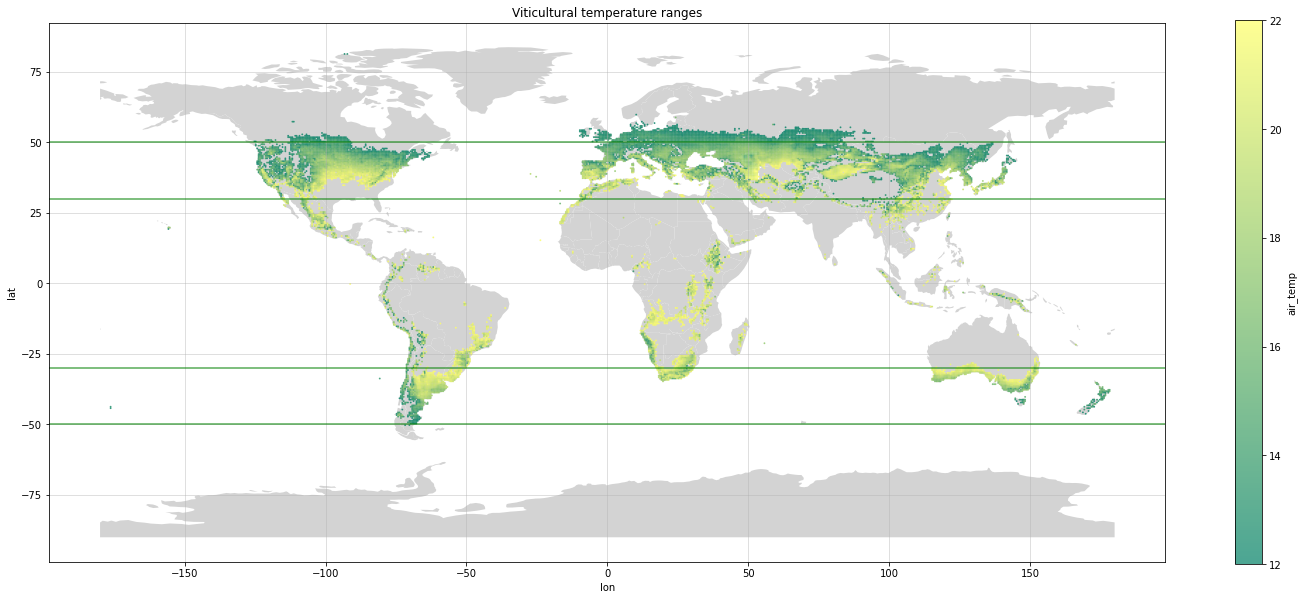

In [11]:
%matplotlib inline
import geopandas as gpd

fig, ax = plt.subplots(figsize=(25,10))

map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
map.plot(color="lightgrey", ax=ax)

# Show the temperature ranges for year 1900 now
in_range.loc[1900].plot(
        x="lon", y="lat", kind="scatter", 
        c="air_temp", colormap="summer", 
        title=f"Viticultural temperature ranges", alpha=0.7, s=0.8,
        ax=ax
        )

# Plotting lines at 30, 50 and -30, -50 latitudes
ax.grid(b=True, alpha=0.5)
ax.axhline(y=30, linewidth=2, color='g', alpha=0.5)
ax.axhline(y=50, linewidth=2, color='g', alpha=0.5)
ax.axhline(y=-30, linewidth=2, color='g', alpha=0.5)
ax.axhline(y=-50, linewidth=2, color='g', alpha=0.5)

plt.show()

C:\Users\agelanyi\AppData\Local\Temp\ipykernel_12180\1752677212.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


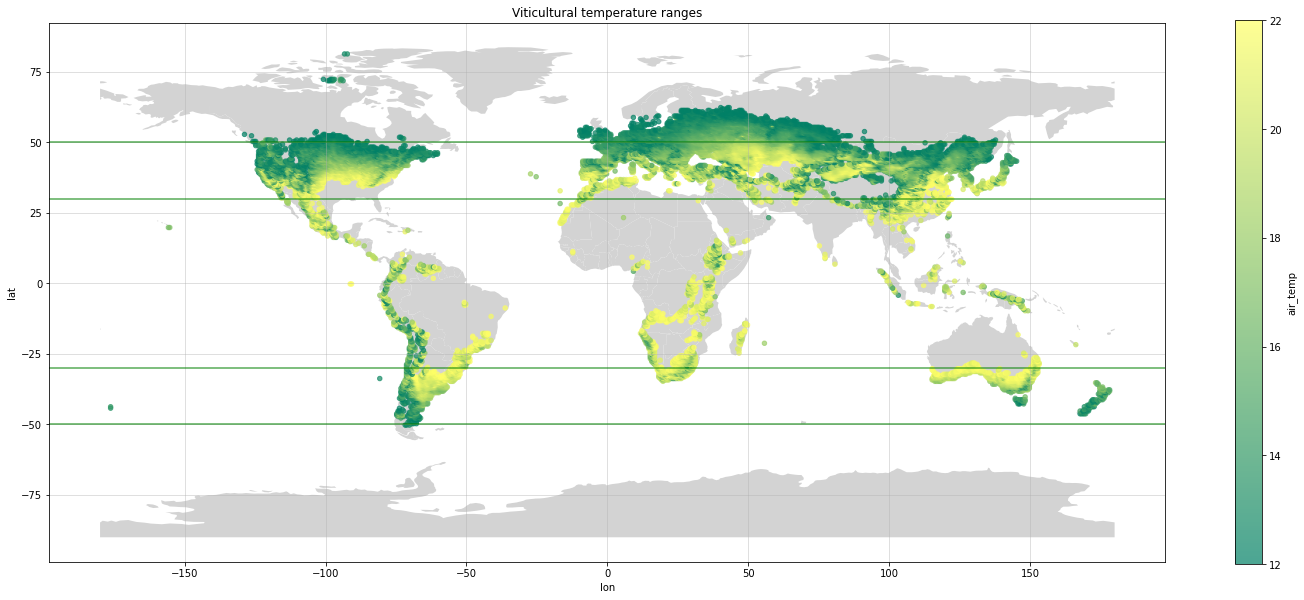

In [12]:
%matplotlib inline
import geopandas as gpd



fig, ax = plt.subplots(figsize=(25,10))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

# Show the temperature ranges for year 2010 now
in_range.loc[2010].plot(
        x="lon", y="lat", kind="scatter", 
        c="air_temp", colormap="summer", 
        title=f"Viticultural temperature ranges", alpha=0.7,
        ax=ax
        )

# Plotting lines at 30, 50 and -30, -50 latitudes
ax.grid(b=True, alpha=0.5)
ax.axhline(y=30, linewidth=2, color='g', alpha=0.5)
ax.axhline(y=50, linewidth=2, color='g', alpha=0.5)
ax.axhline(y=-30, linewidth=2, color='g', alpha=0.5)
ax.axhline(y=-50, linewidth=2, color='g', alpha=0.5)

plt.show()

In [ ]:
# Generating images for all the years
import geopandas as gpd

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

for year in range(1900, 2018):

    print(f"Working on year: {year}")

    fig, ax = plt.subplots(figsize=(25,10))

    countries.plot(color="lightgrey", ax=ax)

    in_range.loc[year].plot(
            x="lon", y="lat", kind="scatter", 
            c="air_temp", colormap="summer", 
            title=f"Viticultural temperature ranges in year {year}", alpha=0.7, s=0.8,
            ax=ax
            )

    ax.grid(visible=True, alpha=0.5)
    ax.axhline(y=30, linewidth=2, color='g', alpha=0.5)
    ax.axhline(y=50, linewidth=2, color='g', alpha=0.5)
    ax.axhline(y=-30, linewidth=2, color='g', alpha=0.5)
    ax.axhline(y=-50, linewidth=2, color='g', alpha=0.5)

    # Saving the image
    plt.savefig(f"images/{year}.png", facecolor="auto")
    # Let's not show the generated plot
    plt.close(fig)


In [ ]:
# building an animation and saving it as a GIF

import os
import imageio

png_dir = 'images/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('images/900-2017.gif', images, fps=5)
